## Modelling flow through the homeless services system with an M(t)/M/s(t) queue

The DES model of flow through the homeless services system (Singham et al. (2023) illustrates the effects of different investment policies (building a mix of temporary shelter and permanent accommodation) on the homeless population involved. A key metric for measuring the success of a policy is the number of homeless people who remain unsheltered throughout the modelled 6 year time window. There are two "versions" of this model - a general one with a homogeneous population and homogeneous accommodation and a more detailed one where the population is categorised in terms of specific housing need, the accommodation to meet that need is also categorised and different categories of the population have different pathways through the system. 

Here we look specifically at the general version of the model and we attempt to provide an alternative way of modelling the system using an exact analytical model of approximation of the DES model. The motivation for this is two-fold. Firstly, two different models of the same system can add extra insight on and understanding of the underlying system. Secondly, a future simulation optimisation approach may well benefit from an analytical model to guide the search of the simulation solution space. 

### The analytical model

The analytical model we use is an M(t)/M/s(t) queue with the following features: 

* The time-dependent Poisson arrival process is a direct equivalent of the arrival process used in the DES model. 
* The exponential distribution we use to model service time (time spent in permanent accommodation) is an approximation of the triangular distribution used in the DES model with the same mean service time. The exponential distribution is favourable for the analytical model because it enables the use of numerical integration to analyse the dynamics of the system. 
* The time-dependent number of servers (i.e. number permanent accommodation units) is a direct equivalent of the time-dependent number of servers in the DES model. 
* The number of shelters (which is directly modelled in the DES model) is not directly modelled in the analytical model, but it is incorporated in the analysis of the dynamics of the queue - the queue for the permanent accommodation at a given time can be "split out" into the sheltered and the unsheltered population, where point in the queue where the split is made is time dependent.

The state space is the number of people in the system, and we compute the probability of being in each state at any point in discretised time by using numerical integration. using this method, within sufficiently small intervals, we can assume the arrival rate is constant and also assume that at most one state change can occur in that time interval. Therefore, if we know the probabilities $p_n(t)$ of being in all states $n \in \{0,1,...,N-1,N\}$ at some time $t \in \{0,1,...,T-1,T\}$, then at time $t+d$, where $d$ is the small time-interval, we can give the probability $p_n(t+d)$ of being in some state $n$ as: 

$p_n(t+d) = p_{n-1}(t)[\lambda(t)d] + p_{n}(t)[1-\lambda(t)d-\mu(t)m_n d] + p_{n+1}(t)[\mu(t)m_{n+1} d]$

where $\lambda(t)$ is the arrival rate at time $t$, $\mu(t)$ is the service rate at time $t$ and $m_n$ is the number of busy servers when the system is in state $n$. 

Given an initial number of people in the system, and a fixed maximum number of people in the system which we set to be very large, we can iteratively compute all state probabilites in the time interval $\{d,2d,...,T\}$. These probabilities can then be analysed to determine the following time-dependent metrics:

* the expected number of people in the system,
* the expected number of people in the queue (both sheltered and non-sheltered),
* the expected number of unsheltered people. 

The python module accompanying this notebook, called "queueing_model.py" contains the code required (wrapped up in a "queue" class) to model such a queue and calculate the desired metrics. It also contains contains a function "mms_steadystate($\lambda$, $s$, $\mu$)" which gives the steady state results for an M/M/s queue and function for plotting. 

In [1]:
import queueing_model as qm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

### Steady state behaviour of M/M/s queue

First, it is helpful to test our queueing model against the known steady state behaviour of a time-homogeneous queue. Steady state behaviour is only observed when the arrival rate is less than the service rate multiplied by the number of servers. 

As an example, we use the following parameters: 

In [2]:
# steady state parameters for testing
arrival_rate = 35
service_rate = 12
n_servers = 4
print("Arrival rate:", arrival_rate, "people enter system per year")
print("Service rate:", service_rate, "people exit each accommodation unit per year")
print("Number of accommodation units", n_servers, "units")

Arrival rate: 35 people enter system per year
Service rate: 12 people exit each accommodation unit per year
Number of accommodation units 4 units


The known steady-state behaviour (number in the system, number in the queue) is computed below: 

In [3]:
n_sys, n_queue = qm.mms_steadystate(arrival_rate, n_servers, service_rate)
print("Steady state number in the system: ", round(n_sys,3))
print("Steady state number in queue (sheltered + unsheltered): ", round(n_queue,3))

Steady state number in the system:  4.196
Steady state number in queue (sheltered + unsheltered):  1.279


Now, we check that our queueing model (analysed using numerical integration, as described above) is working correctly by using it to model the dynamics of a queue with the same steady state set up for arrival rate, service rate and the number of servers. 

In [4]:
# parameters to model queue (MMs steady state)
annual_arrival_rate = [35, 35, 35, 35, 35, 35] # six entries, one for each year over 6 years. 
mean_service_time = 1/12 # per year
servers_initial = 4
shelter_initial= 0
server_build_rate = [0,0,0,0,0,0] # six entries, one for each year over 6 years. 
shelter_build_rate = [0,0,0,0,0,0] # six entries, one for each year over 6 years. 
num_in_system_initial = 0
max_in_system = 100

In [5]:
# create instance of queue
q = qm.queue(annual_arrival_rate, 
             mean_service_time, 
             servers_initial, 
             shelter_initial, 
             server_build_rate, 
             shelter_build_rate, 
             num_in_system_initial, 
             max_in_system)

# model dynamics of the queue (this updates several attributes of q)
q.model_dynamics(Y=6,d=1) # Y : time horizon for analysis in integer years, d: width of time step in days. 

The plots below show the expected number in the system and number in the queue, over a six year time window. The dashed lines indicate the known values as previously calculated. These plots illustrate that our numerical integration is converging to the correct solution which gives us some trust that the model is behaving properly. 

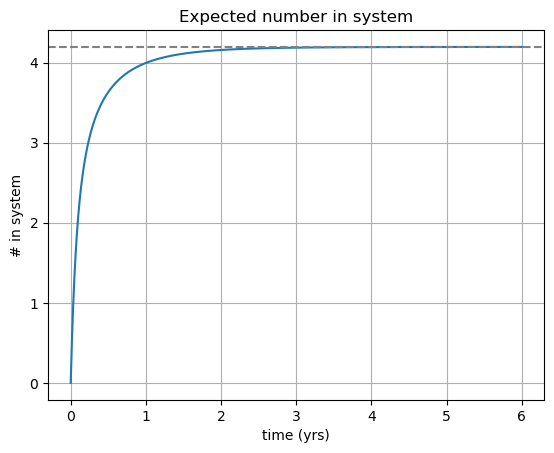

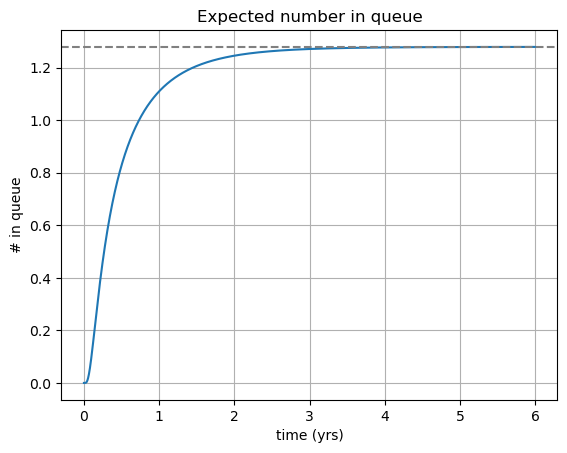

In [6]:
# plot queue dynamics - num in system
fig, ax = plt.subplots()
ax.plot(np.arange(0,6,1/365), q.num_sys)
plt.axhline(y = n_sys, color = 'gray', linestyle = 'dashed')

ax.set(xlabel='time (yrs)', ylabel='# in system',
       title='Expected number in system')
ax.grid()

plt.show()

# plot queue dynamics - number in queue
fig, ax = plt.subplots()
ax.plot(np.arange(0,6,1/365), q.num_queue)
plt.axhline(y = n_queue, color = 'gray', linestyle = 'dashed')

ax.set(xlabel='time (yrs)', ylabel='# in queue',
       title='Expected number in queue')
ax.grid()

plt.show()

### Time dependent behaviour of M(t)/M/s(t) queue

We now make an instance of a queue where we have copied parameters directly from the Simio DES model of Singham et al. (2023).
It should be noted that we have assumed re-entries to the system come at a steady rate throughout the time horizon modelled. We have set that rate to correspond with the service rate from the initial number of accommodation units. 

In [7]:
# model queue (time dependent homeless services system)
servers_initial = 40
shelter_initial = 15
server_build_rate = [3,6,7,10,8,4] # number of servers to be added at start of every two months incl month 0 (different value in each of six years)
shelter_build_rate = [2,2,0,-2,-1,-1] # number of shelters to be added at start of every two months incl month 0 (different value in each of six years)
mean_service_time = (1/52)*(0+300+400)/3 # mean (years) of the triangular(0,300week,400week) distribution 
annual_arrival_rate = [35.0400, 42.0048, 46.2528, 46.2528, 41.6100, 37.4052] # six entries, one for each year over 6 years. 
reentry_rate = 0.17 # the proportion of those leaving accommodation which re-enter the system some time later
annual_arrival_rate_reentries = (servers_initial*reentry_rate)/mean_service_time # assuming re-entries from the initial number of servers
annual_arrival_rate = [i+annual_arrival_rate_reentries for i in annual_arrival_rate]
num_in_system_initial = 120
max_in_system = 1000

In [8]:
print('The arrival rates, including re-entries, result in the following annual and hourly arrival rates')
print('------------------------')

yr = 1
for rate in annual_arrival_rate:
    print('Year ' + str(yr) + ': annual arrival rate of ' + str(rate))
    yr+=1
    
print('------------------------')
    
yr = 1
for rate in annual_arrival_rate:
    print('Year ' + str(yr) + ': hourly arrival rate of ' + str(rate/8760))
    yr+=1
    
print('------------------------')
print('The mean service time in weeks at each accommodation unit is: ' + str(mean_service_time*52))

The arrival rates, including re-entries, result in the following annual and hourly arrival rates
------------------------
Year 1: annual arrival rate of 36.55542857142857
Year 2: annual arrival rate of 43.520228571428575
Year 3: annual arrival rate of 47.76822857142857
Year 4: annual arrival rate of 47.76822857142857
Year 5: annual arrival rate of 43.12542857142857
Year 6: annual arrival rate of 38.92062857142857
------------------------
Year 1: hourly arrival rate of 0.004172994129158513
Year 2: hourly arrival rate of 0.004968062622309198
Year 3: hourly arrival rate of 0.005452994129158513
Year 4: hourly arrival rate of 0.005452994129158513
Year 5: hourly arrival rate of 0.004922994129158513
Year 6: hourly arrival rate of 0.0044429941291585125
------------------------
The mean service time in weeks at each accommodation unit is: 233.33333333333334


In [9]:
q = qm.queue(annual_arrival_rate, mean_service_time, servers_initial, shelter_initial, server_build_rate, shelter_build_rate, num_in_system_initial, max_in_system)
q.model_dynamics(Y=6,d=1) # Y : time horizon for analysis in integer years, d: width of time step in days. 

The plots below show the expected number in the system, the expected number in the queue (sheltered and unsheltered) and the expect number of people unsheltered. 

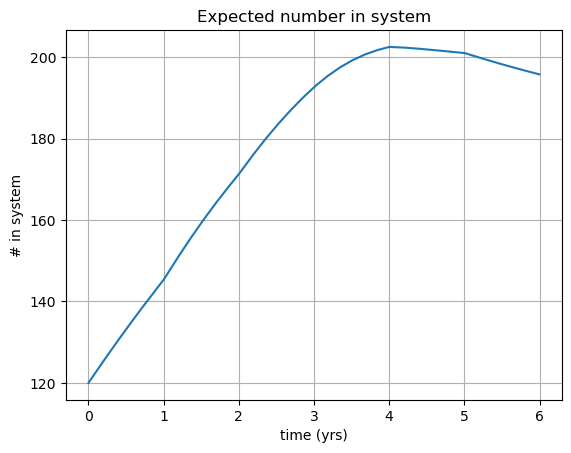

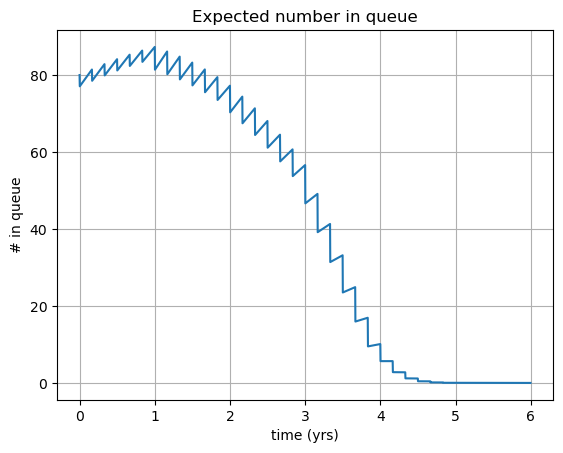

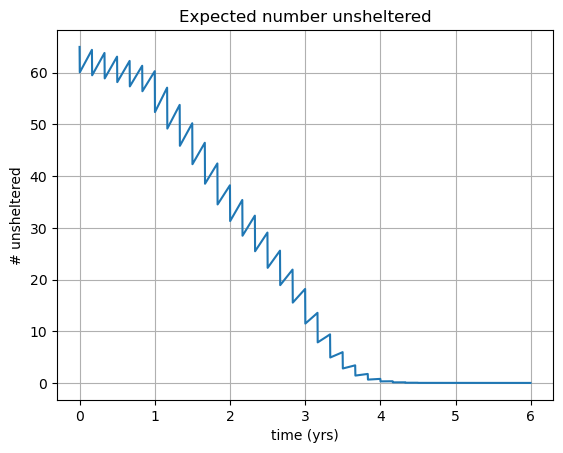

In [10]:
# plot queue dynamics - num in system
fig, ax = plt.subplots()
ax.plot(np.arange(0,6,1/365), q.num_sys)

ax.set(xlabel='time (yrs)', ylabel='# in system',
       title='Expected number in system')
ax.grid()

plt.show()

# plot queue dynamics - number in queue
fig, ax = plt.subplots()
ax.plot(np.arange(0,6,1/365), q.num_queue)

ax.set(xlabel='time (yrs)', ylabel='# in queue',
       title='Expected number in queue')
ax.grid()

plt.show()

# plot queue dynamics - number unsheltered
fig, ax = plt.subplots()
ax.plot(np.arange(0,6,1/365), q.num_unsheltered)

ax.set(xlabel='time (yrs)', ylabel='# unsheltered',
       title='Expected number unsheltered')
ax.grid()

plt.show()

The expected number of people unsheltered drops every two months as new shetler and accommodation is built. The general trajectory is initially downward as the extra shelter and accommodation built every two months outweighs the growth of the queue in the two month time period. During the fifth year, there is no longer an unsheltered population. 

### Comparison with DES model

To compare these model outputs with the DES model, we make minor modifications to V1 of the simple model in Simio to make it a direct equivalent to the analytical queueing model. The changes are summarised below: 

* The service time distribution of the DES model is changed to be exponential, with the same mean as the original triangular distribution. 

* The DES pathway leaving permanent accommodation and returning to queue for shelter (originally applying to on average 17% of those leaving permanent accommodation) is removed as it is not possible to model this specific behaviour in the analyical queueing model. 

* To account for this removed pathway, the time-dependent Poisson arrival process in the DES model is increased at all times by a constant factor to account for 17% of people leaving 40 units of permanent accommodation (given the service time of those units) re-entering the system from the start. 

We perform 1000 replications of this DES model and monitor the number of unsheltered people at 2 month intervals. The data is collected every two months, momentarily before new shelter / accommodation is added to the system and occupied. We collect the equivalent data from the queueing model, i.e. just before new shelter/accommodation is added.

In [11]:
# read simulation data from file
data_sim = []
unsheltered_initial = num_in_system_initial - servers_initial - shelter_initial # to add to the first row of each data file

for i in range(1000):
    run = i+1
    file_name = 'data/simio_outputs/2023-07-27-SimpleModelAC_IncV2/SimOutput_Experiment1_Scenario 4_Rep' + str(run) + '.xlsx'
    sim_out = pd.read_excel(file_name)
    sim_out.columns = ['housing_capacity', 'shelter_capacity', 'housing_occupied', 'shelter_occupied', 'num_unsheltered', 'last_shetler_time']
    data_sim.append(np.array(pd.concat([pd.Series([unsheltered_initial]), sim_out['num_unsheltered'][1:]])))
    
data_sim = np.array(data_sim).T    

In [12]:
# get the queue data we need (i.e. the data just before new shelter/accommodation is filled every 2 months)
index_list = [0]
day = 1
two_months_in_days = 365/6
num_two_months = 0
sim_length = data_sim.shape[0]-1 # length in units of two months

while num_two_months < sim_length:
    if math.floor((day+1)/two_months_in_days) > math.floor((day)/two_months_in_days):
        index_list.append(day)
        num_two_months += 1
    day += 1
    
data_q = [q.num_unsheltered[i] for i in index_list]

Below we overlay the spread of the simulation results with the analytical results from the queueing model. From the simulation data we display four different percentile ranges. From the queueing model we display the daily data with a thin dotted line and bi-monthly data (just before new shelter / accommodation is added) with a thicker solid line. The latter bimonthly data from the queueing model is equivalent to the simulation data, and we can see that until time $t\approx 3.5 \text{ years}$, the expected value of the number of unsheltered people from the queueing model sits between the 40th and 60th percentile of this quantity from the simulation model, indicating good agreement between the two models. Between time $t\approx 3.5 \text{ years}$ and $t\approx 4 \text{ years}$, when the expected value of the number of unsheltered people is less than 5, the simulation model shows a quicker fall to an empty queue of unsheltered people. This is likely due to the fact that in any given simulation run, as soon as the number of unsheltered people drops to zero, no more events are scheduled and this number remains at zero, whereas the queueing model allows for the possibility of new unsheltered people after a state of zero unsheltered people. 

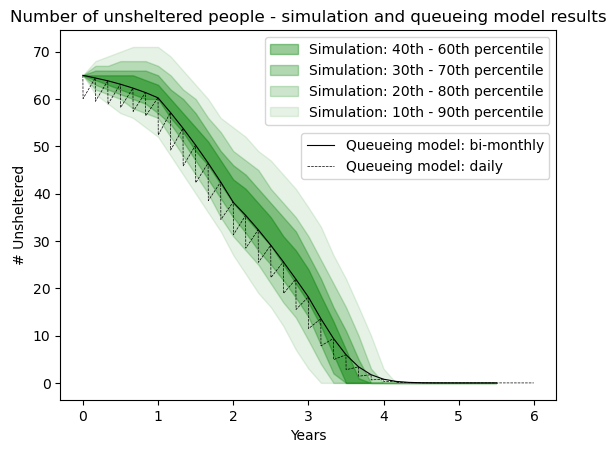

In [13]:
# create fan chart
fig, ax = qm.create_fanchart(data_sim, data_q, q)